  
# **Managing PnL with Tokens (simplified)

This notebook simulates a company's **profit and loss (PnL) management** when accepting payments in both **USD and a volatile crypto token**. The goal is to understand how financial decisions impact the company's cash flow, token reserves, and overall financial stability.

This is a relatively simple starter notebook to get you comfortable with a PnL; we've assumed there is no direct need for tokens within the company, and that the market it liquid enough to support token sales without impacting the market. These assumptions should be replaced with context specific secondary market factor model, user price-sensitive demand model and company token-use models for any particular company operating within a tokenized ecosystem. These three additional models may provide more realistic circumstances for managing your PnL.

## **Key Features of the Model**
- Customers can purchase services using either **USD** or **crypto tokens**.
- The **crypto token price follows Brownian motion**, making it volatile.
- The company needs to **manage both USD and token balances** over time.
- Key financial decisions include:
  - **Setting a conversion rate for tokens** (USD per token).
  - **Selling tokens to maintain a target cash balance**.
  - **Pricing services appropriately** to ensure sustainability.

## **Structure of the Notebook**
This notebook is divided into sections to **incrementally build the model** with clear explanations at each step:
1. **Model Parameters** – Define core constants such as cost function parameters, pricing strategies, and volatility assumptions.
2. **State Variable Initialization** – Set initial balances for USD, tokens, and track prior states.
3. **Helper Functions** – Define key calculations, such as cost estimation and token price updates.
4. **Simulation Execution** – Simulate multiple time periods to observe system behavior.
5. **Analysis and Visualization** – Plot results and summarize key takeaways.



## **1. Import Required Libraries**

Before defining our model, we need to import essential Python libraries:

- `numpy`: For numerical computations, including random number generation for token price fluctuations.
- `pandas`: To store and process the simulation results efficiently.
- `matplotlib`: To generate plots and visualize trends over time.

This model was written using basic numerical python tools for accessibility. Advance specification and simulation frameworks such as MSML and cadCAD are used by BlockScience. MSML helps manage modularity of complex systems made of many subsystems, and cadCAD helps control large scale repeated simulations across a wide range of parameterizations for comparasion with trajectory level KPIs. Consider using those tools if you model becomes complex.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
    

## **2. Define Model Parameters**

| Name                      | Notation         | Actor      | Explanation  |
|---------------------------|-----------------|-----------|-------------|
| Fixed Cost               | $a$              | Company   | Base cost per period, independent of service demand. |
| Variable Cost Scaling    | $b$              | Company   | Determines how costs increase as demand grows, following a logarithmic function. |
| Conversion Rate Smoothing | $\lambda$      | Company   | Controls how quickly the company's token conversion rate adapts to price changes (exponential smoothing). |
| Service Price            | $q$              | Company   | The fixed price of the service per unit, set by the company. |
| Runway Horizon           | $h$              | Company   | Determines how many periods of expenses the company aims to hold in cash. |
| Mean Demand              | $\mu$            | Users     | Represents the average demand for services, influencing how often users purchase with USD or tokens. |
| Demand Covariance Matrix | $\Sigma$         | Users     | Models the relationship between token-based and USD-based service purchases. |
| Token Price Drift        | $\mu$            | Traders   | Represents the long-term expected movement of token price (upward, downward, or neutral). |
| Token Price Volatility   | $\sigma$         | Traders   | Determines the randomness and fluctuations in token price, affecting risk exposure. |
| Simulation Time Steps    | $T$              | System    | The number of periods simulated in the model. |




In [2]:
# Cost function parameters
a = 5      # Fixed cost per time period
b = 0.5    # Scaling coefficient for variable costs

# Token price model parameters
mu = 0.00  # Drift (average rate of token price change)
sigma = 0.05  # Volatility (uncertainty in token price movements)

# Business policy parameters
lambda_r = 0.2  # Exponential smoothing parameter for conversion rate
q = 6          # Fixed service price (in USD per unit)
h = 5           # Runway horizon: cash reserve target in periods

# Simulation parameters
T = 100  # Number of time steps
np.random.seed(42)  # Fix random seed for reproducibility
    


## **3. Initialize State Variables**

| Name                      | Notation         | Actor      | Explanation  |
|---------------------------|-----------------|-----------|-------------|
| USD Balance              | $y$              | System    | The company's cash balance in USD, updated each period based on revenues, costs, and token sales. |
| Token Balance            | $z$              | System    | The number of tokens held by the company, affected by token payments and sales. |
| Token Price              | $p$              | Market    | The USD price per token, fluctuating according to a stochastic Brownian motion model. |
| Conversion Rate          | $r$              | Company   | The rate at which the company accepts tokens for payments, updated using exponential smoothing. |
| Total Service Demand     | $x$              | Users     | The total amount of service requested in a given period, split between USD and token-based purchases. |
| Token-Based Demand       | $u_1$            | Users     | The portion of service purchases made using tokens. |
| USD-Based Demand         | $u_2$            | Users     | The portion of service purchases made using USD. |
| Tokens Sold              | $w$              | Company   | The number of tokens sold by the company in a given period to maintain cash reserves. |
| Maximum Observed Cost    | $c_{\max}$       | System    | The highest observed cost so far, used for determining the required runway in cash reserves. |




In [3]:

# Initial conditions
y = [100]     # Initial USD balance
z = [50]      # Initial token balance
p = [1]       # Initial token price (USD per token)
r = [1]       # Initial conversion rate USD/TOK
x = [0]       # Initial service demand
u1 = [0]      # Initial service bought with tokens
u2 = [0]      # Initial service bought with USD
w = [0]       # Initial tokens sold
c_max = a     # Initialize max observed cost
    


## **4. System Dynamics**

This section executes the **PnL simulation** over multiple time steps. Each period consists of **five key steps**, linking directly to the **state variables and business policies** defined earlier.

---

### **4.1. Updating the Token Price**

The external **crypto market** determines token price fluctuations. We model this using a **discrete Brownian motion process**, where prices follow an exponential drift with random fluctuations:

$$
p[t] = p[t-1] \times e^{(\mu + \sigma W_t)}
$$

- **$p[t]$** is the updated token price.
- **$\mu$** (drift) and **$\sigma$** (volatility) are parameters **set by traders** (see parameter table).
- **$W_t$** is a random variable drawn from a normal distribution, capturing market uncertainty.

---

### **4.2. Generating Customer Demand**

Users purchase services with **USD ($u_2$) or tokens ($u_1$)**. Their behavior follows a **correlated normal distribution**:

- **$u_1[t]$**: Services bought with tokens.
- **$u_2[t]$**: Services bought with USD.
- **Total service demand** is the sum of both:

$$
x[t] = u_1[t] + u_2[t]
$$

- The **mean and covariance matrix** control demand variations (set by users).
- **Higher $x[t]$ means higher operating costs**.

---

### **4.3. Computing Service Costs**

The **company incurs costs** based on the total service demand. We model this using a **logarithmic function**, ensuring that **marginal costs decrease at high volumes**:

$$
c(x) = a + \log(1 + b \cdot x)
$$

- **$a$** is the **fixed cost** per period.
- **$b$** controls the scaling of variable costs.

The **company wants to track** the **maximum observed cost** ($c_{\max}$), as it influences cash reserve targets in step 5.

---

### **4.4. Updating Financial Balances**

Once services are provided, **revenues are collected**, and **costs are deducted**:

- **USD balance ($y$) updates** by adding USD revenue and subtracting costs:

$$
y[t] = y[t-1] + u_2[t] \cdot q - c(x[t])
$$

- **Token balance ($z$) updates** based on services bought with tokens:

$$
z[t] = z[t-1] + \frac{u_1[t] \cdot q}{r[t]}
$$

Here:
- **$q$** is the **fixed service price** (set by the company).
- **$r[t]$** is the **conversion rate**, which determines how many tokens are accepted per USD.

---

### **4.5. Selling Tokens to Maintain Cash Reserves**

The company needs enough **cash ($y$) to cover future costs**. It sells tokens ($w[t]$) to reach a **target cash balance ($y^*[t]$), based on a predefined runway horizon ($h$)**:

$$
y^*[t] = h \cdot c_{\max}
$$

- **If the cash balance is below target**, the company sells **just enough tokens** to reach it:

$$
w[t] = \min \left( \frac{y^*[t] - y[t]}{p[t]}, z[t] \right)
$$

- If there **aren't enough tokens** to reach $y^*[t]$, **the company sells all available tokens**.

After selling, **final financial updates** are made:

$$
y[t] = y[t] + w[t] \cdot p[t]
$$

$$
z[t] = z[t] - w[t]
$$

- **$w[t]$ represents the number of tokens sold**.
- **$p[t]$ is the token price in USD**.

---

This **sequential process** ensures that the **company stays solvent**, balances its **USD and token holdings**, and adapts to **market volatility and user demand**.

In [4]:
# implementing the dynamics as a simulation
for t in range(1, T):
    # Update token price
    p.append(p[t-1] * np.exp(mu + sigma * np.random.randn()))

    # Generate random user demand
    u1.append(np.random.randint(0, 10))  # Service bought with tokens
    u2.append(np.random.randint(0, 10))  # Service bought with USD
    x.append(u1[t] + u2[t])  # Total service demand

    # Compute cost and update max observed cost
    c_t = a + np.log(1 + b * x[t])
    c_max = max(c_max, c_t)  # Track max observed cost

    # Compute new conversion rate
    r.append((1 - lambda_r) * r[t-1] + lambda_r * p[t-1])

    # Compute revenues
    usd_revenue = u2[t] * q
    token_revenue = (u1[t] * q) / r[t]

    # Update balances before selling tokens
    y.append(y[t-1] + usd_revenue - c_t)
    z.append(z[t-1] + token_revenue)

    # Compute token sale decision
    w.append(min((h * c_max - y[t]) / p[t], z[t]))

    # Execute token sale
    y[t] += w[t] * p[t]  
    z[t] -= w[t]
    

In [5]:
# Store results in a DataFrame
df = pd.DataFrame({
    'time': range(T),
    'x': x,
    'y': y,
    'z': z,
    'p': p,
    'r': r,
    'u1': u1,
    'u2': u2,
    'w': w
})


In [6]:
# inspect the results
df

,time,x,y,z,p,r,u1,u2,w
0,0,0,100.000000,50.000000,1.000000,1.000000,0,0,0.000000
1,1,11,34.359011,172.738872,1.025147,1.000000,7,4,-80.738872
2,2,15,35.700331,253.268796,1.018084,1.005029,6,9,-44.710074
3,3,9,35.700331,300.079467,1.032388,1.007640,7,2,-5.129130
4,4,9,35.700331,345.633722,1.085890,1.012590,5,4,-15.927253
...,...,...,...,...,...,...,...,...,...
95,95,15,36.512925,4630.919484,1.288478,1.205144,9,6,-22.398475
96,96,11,36.512925,4679.485023,1.199214,1.221810,8,3,-9.279576
97,97,8,36.512925,4713.161480,1.233938,1.217291,2,6,-23.818503
98,98,2,36.512925,4718.311963,1.306026,1.220621,1,1,-0.234951


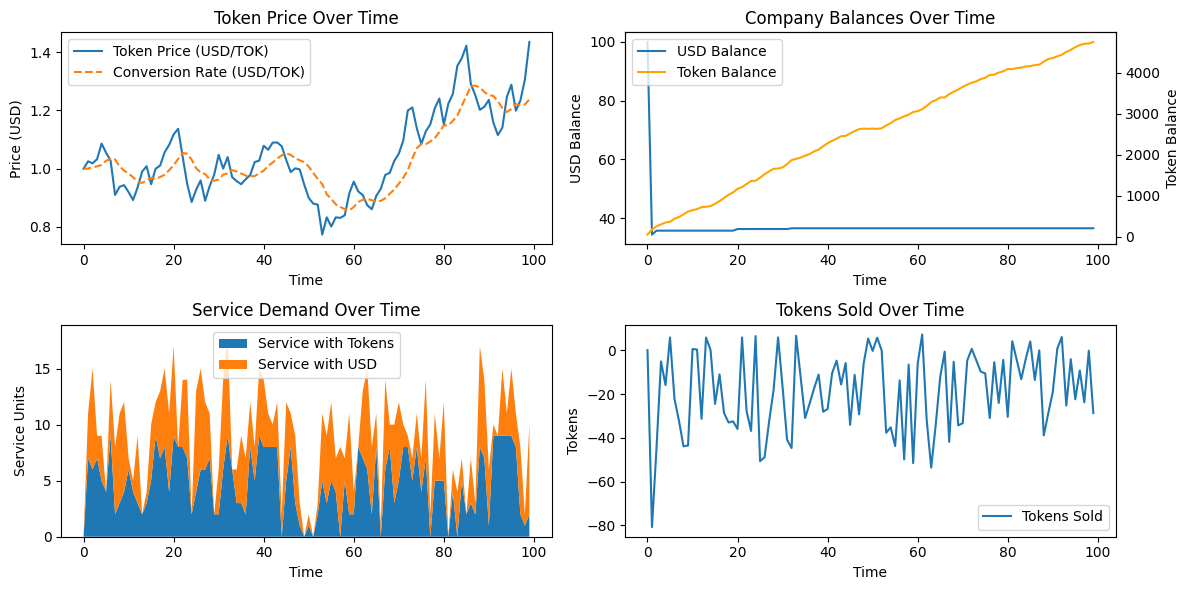

In [7]:
fig, ax1 = plt.subplots(2, 2, figsize=(12, 6))

# Token price over time
ax1[0, 0].plot(df['time'], df['p'], label="Token Price (USD/TOK)")
ax1[0, 0].plot(df['time'], df['r'], label="Conversion Rate (USD/TOK)", linestyle='--')
ax1[0, 0].set_xlabel("Time")
ax1[0, 0].set_ylabel("Price (USD)")
ax1[0, 0].set_title("Token Price Over Time")
ax1[0, 0].legend()

# USD and token balance over time
ax1[0, 1].plot(df['time'], df['y'], label="USD Balance")
ax1[0, 1].set_ylabel("USD Balance")
ax1[0, 1].set_xlabel("Time")
ax1[0, 1].set_title("Company Balances Over Time")

ax2 = ax1[0, 1].twinx()
line1, = ax2.plot(df['time'], df['z'], label="Token Balance", color='orange')
ax2.set_ylabel("Token Balance")

# Combine legends
lines, labels = ax1[0, 1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + [line1], labels + labels2, loc='upper left')

# Service demand
ax1[1, 0].stackplot(df['time'], df['u1'], df['u2'], labels=["Service with Tokens", "Service with USD"])
ax1[1, 0].set_xlabel("Time")
ax1[1, 0].set_ylabel("Service Units")
ax1[1, 0].set_title("Service Demand Over Time")
ax1[1, 0].legend()

# Token sales
ax1[1, 1].plot(df['time'], df['w'], label="Tokens Sold")
ax1[1, 1].set_xlabel("Time")
ax1[1, 1].set_ylabel("Tokens")
ax1[1, 1].set_title("Tokens Sold Over Time")
ax1[1, 1].legend()

plt.tight_layout()
plt.show()


## **5. Understanding the Visualizations**

The following plots help us analyze how the company's financial state evolves over time under the given policies. Each chart provides insight into a different aspect of the system's behavior.

---

### **5.1. Token Price Over Time**
**Axes:**
- **X-axis:** Time step ($t$)
- **Y-axis:** Token price ($p[t]$) in USD

**Interpretation:**  
This plot shows how the token price fluctuates over time, driven by the **Brownian motion model** with drift ($\mu$) and volatility ($\sigma$).  
- A **stable or increasing** trend may indicate favorable market conditions.  
- A **volatile or declining** trend could affect company revenue from token payments.  

---

### **5.2. Company Balances Over Time**
**Axes:**
- **X-axis:** Time step ($t$)
- **Y-axis:** USD balance ($y[t]$) and Token balance ($z[t]$)

**Interpretation:**  
This plot tracks the company’s **cash reserves (USD) and token holdings** over time.  
- The **USD balance ($y[t]$)** fluctuates due to revenues, costs, and token sales.  
- The **Token balance ($z[t]$)** is affected by customers purchasing with tokens and the company liquidating tokens for cash.  
- A **declining USD balance** suggests that costs may be outpacing revenue.  
- A **high token balance but low USD balance** may indicate a need for more token sales.  

---

### **5.3. Service Demand Over Time**
**Axes:**
- **X-axis:** Time step ($t$)
- **Y-axis:** Total service demand ($x[t]$)

**Interpretation:**  
This chart shows how many service units are being purchased over time.  
- Demand is composed of **USD-based purchases ($u_2[t]$) and token-based purchases ($u_1[t]$)**.
- Fluctuations in demand may result from **price changes, token price volatility, or external factors**.
- A **consistent or growing demand** suggests stable user engagement, whereas **high volatility** may indicate sensitivity to price changes.

---

### **5.4. Tokens Sold Over Time**
**Axes:**
- **X-axis:** Time step ($t$)
- **Y-axis:** Tokens sold ($w[t]$)

**Interpretation:**  
This plot represents the company’s **token liquidation strategy** in action.  
- The company sells tokens **to maintain a target cash reserve ($y^*[t]$)**.
- If **token sales spike**, it may indicate **cash shortages** or **a sharp decline in token value**.
- If **no tokens are being sold**, it suggests either **sufficient USD reserves** or **a deliberate holding strategy**.

---

### **How to Use These Charts**
- Compare the **token price trend** to the **company’s balances**—are token sales reactive to price drops?
- Observe **demand patterns**—does service demand remain stable despite token volatility?
- Analyze **token sales behavior**—is the company offloading tokens aggressively or strategically?
- Identify **liquidity risks**—does the company maintain enough USD reserves across different conditions?

These charts provide a **holistic view of financial stability** and how different actors influence the system.

